# Pytorch Neural Network - Classification

## 1. Data Preprocess
We must prepare the data for the neural network.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

Load scikit-learn breast cancer data set.

Then we load the features into a 2D array (matrix X - all features) and load the target into a vector (vector Y - classification)

Malignant - 1
Benign = 0

In [2]:
data = load_breast_cancer()
X = data.data.astype(np.float32)
y = data.target.astype(np.float32).reshape(-1, 1)

Normalize the input features. We want the *mean 0* and the *standard deviation 1*. All features are centered and scaled evenly. Neural networks learn faster and better when input features are on a similar scale. Without normalization, some features can dominate others. We only normalize the input features.

In [3]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

We must split the data into training and validation. This ensures we have a way to test our neural network without giving the model access to "answers" during training.

- X_train is our input feature training split
- y_train is our target for training split (the answers)
- X_val is the input feature for validation
- y_val is our target for validation


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Convert all the data, both training and validation sets into pytorch tensors, so the neural network can work with the data.


In [5]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_val   = torch.tensor(X_val)
y_val   = torch.tensor(y_val)
print(X_train.shape)
print(y_train.shape)

torch.Size([455, 30])
torch.Size([455, 1])


## 2. Neural Network Architecture
Design of the neural network ie; layers, forward pass, loss-function, and optimizer.

Define the neural network model (input layers and hidden layers). This is the "forward pass".
- build a sequential network
- we use linear layers that performs $z = W \cdot x + b$
- ReLU is our activation function to introduce non-linearity after each layer, allows the network to learn complex patterns and zeros out negatives (Like sigmoid but a different activation function).
- For classification, we also apply the activation function (sigmoid) after the final output layer which is part of the loss function.

In [6]:
model = nn.Sequential(
    nn.Linear(30, 64),      # Input layer → Hidden layer 1 (64 neurons created from the 11 input features)
    nn.ReLU(),
    nn.Linear(64, 32),      # Hidden layer 1 → Hidden layer 2 (64 inputs from the previous layers outputs, outputs 32 neurons)
    nn.ReLU(),
    nn.Linear(32, 1)        # Hidden layer 2 → Output (1 value: wine quality)
)

The loss function (BCE) is applied right after we get the final output from the network’s forward pass and right before backpropagation. It measures how far off the prediction is from the actual target. For classification we use **BCEWithLogitsLoss()** which includes sigmoid activation.

The optimizer is what updates the weights and biases based on the gradient of the loss. It uses the learning rate to decide how much to adjust the weights in response to the gradients.

In [7]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## 3. Training Loop
Actually apply the forward pass, loss function, optimizer and the back propagation.

Training loop explanation in order:

- **epochs = 100** - 100 epochs or 100 full iterations of training
- **model.train()** - tells pytorch the model is in training mode
- **optimizer.zero_grad()** - we clear the 0's that were stored from the previous back propagation
- **output = model(X_train)** - actually pass in our training data and initiate the forward pass
- **loss = loss_function(output, y_train)** - compute the MSE loss by passing in the model outputs and the actual answers (quality)
- **loss.backward()** - perform backward propagation, where we compute and apply gradient descent (derivative of loss)
- **optimizer.step()** - applies the gradients (calculated during loss.backward()) to update the model’s weights and biases

In [8]:
train_losses, val_losses = [], []
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = loss_function(output, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = loss_function(val_output, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 0 | Train Loss: 0.6897 | Val Loss: 0.5607
Epoch 10 | Train Loss: 0.0817 | Val Loss: 0.0501
Epoch 20 | Train Loss: 0.0460 | Val Loss: 0.0745
Epoch 30 | Train Loss: 0.0264 | Val Loss: 0.0993
Epoch 40 | Train Loss: 0.0148 | Val Loss: 0.1105
Epoch 50 | Train Loss: 0.0069 | Val Loss: 0.1199
Epoch 60 | Train Loss: 0.0031 | Val Loss: 0.1336
Epoch 70 | Train Loss: 0.0014 | Val Loss: 0.1468
Epoch 80 | Train Loss: 0.0008 | Val Loss: 0.1568
Epoch 90 | Train Loss: 0.0005 | Val Loss: 0.1654


## 4. Evaluation
Below we will
 - plot the loss to see how the model is minimizing loss and learning
 -


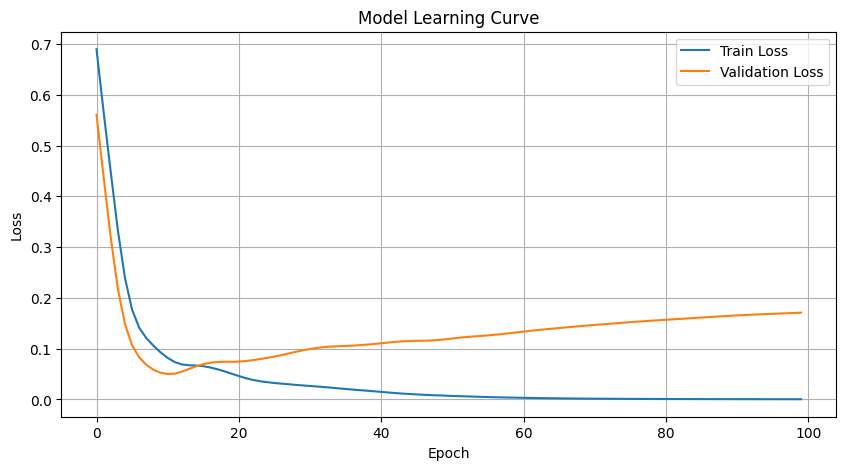

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

As you can see here, we are starting to get some overfitting. Our validation loss is going up while our train loss is staying the same. The model is learning the training data to well and not performing properly on the validation data which is unseen.

There are a few techniques we can use to fix this:
- add ***dropouts*** between the layers - this prevents the model from relying too heavily on any one node
- add ***weight decay (L2 Regularization)*** - this penalizes overly large weights that may be overfitting noise
- add ***early stopping*** - which will detect when the model starts overfitting and stop training to preserve the model
- add ***more data*** - will introduce more variety and the model may be able to pickup on the patterns better


Lets implement early stopping, which will stop training at the best epoch. This is because our dataset is small and doesn't have time to train/pickup the trends. Lets also implement dropouts between the layers as well as weight decay alongside learning rate. The only thing we will not tune is the data itself.

Then we will re-train the model and hope it fixes our overfitting.

In [10]:
tuned_model = nn.Sequential(
    nn.Linear(30, 32),      # Input layer → Hidden layer 1 (64 neurons created from the 11 input features)
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 16),      # Hidden layer 1 → Hidden layer 2 (64 inputs from the previous layers outputs, outputs 32 neurons)
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(16, 1)        # Hidden layer 2 → Output (1 value: wine quality)
)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(tuned_model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses_tuned, val_losses_tuned = [], []
epochs = 100
patience = 10
best_val_loss = float('inf')
counter = 0
best_model_state = None

for epoch in range(epochs):
    tuned_model.train()
    optimizer.zero_grad()

    output = tuned_model(X_train)
    loss = loss_function(output, y_train)
    loss.backward()
    optimizer.step()

    tuned_model.eval()
    with torch.no_grad():
        val_output = tuned_model(X_val)
        val_loss = loss_function(val_output, y_val)

    train_losses_tuned.append(loss.item())
    val_losses_tuned.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0
        best_model_state = tuned_model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

if best_model_state is not None:
    tuned_model.load_state_dict(best_model_state)
    print("Best model weights restored.")

Epoch 0 | Train Loss: 0.6643 | Val Loss: 0.6208
Epoch 10 | Train Loss: 0.1689 | Val Loss: 0.1021
Epoch 20 | Train Loss: 0.0835 | Val Loss: 0.0542
Early stopping triggered at epoch 28
Best model weights restored.


Then re plot the validation and training loss

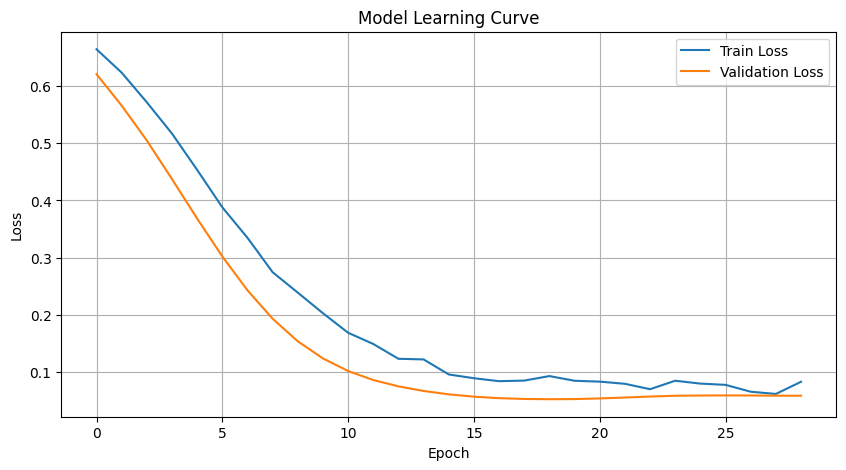

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_tuned, label='Train Loss')
plt.plot(val_losses_tuned, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

As you can see after tuning the model with adding a dropout, adding weight decay, and adding early stopping and simplifying the neural network layers, we have a much better performing model. Time to make some predictions!

In [12]:
model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(X_val)) >= 0.5
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy: {acc * 100:.2f}%")

Validation Accuracy: 98.25%


Finally, lets make some predictions on dataset samples

In [13]:
model.eval()

with torch.no_grad():
    logits = model(X_val[:5])
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()
    actuals = y_val[:5]

for i in range(5):
    print(f"Sample {i+1}:")
    print(f"  Actual Label        → {int(actuals[i].item())}")
    print(f"  Predicted Probability → {probs[i].item():.4f}")
    print(f"  Predicted Class     → {int(preds[i].item())} ({'Malignant' if preds[i] == 1 else 'Benign'})")
    print()

Sample 1:
  Actual Label        → 1
  Predicted Probability → 0.9981
  Predicted Class     → 1 (Malignant)

Sample 2:
  Actual Label        → 0
  Predicted Probability → 0.0000
  Predicted Class     → 0 (Benign)

Sample 3:
  Actual Label        → 0
  Predicted Probability → 0.0000
  Predicted Class     → 0 (Benign)

Sample 4:
  Actual Label        → 1
  Predicted Probability → 1.0000
  Predicted Class     → 1 (Malignant)

Sample 5:
  Actual Label        → 1
  Predicted Probability → 1.0000
  Predicted Class     → 1 (Malignant)

